In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

Outcome: 1  Action: (8, 4)


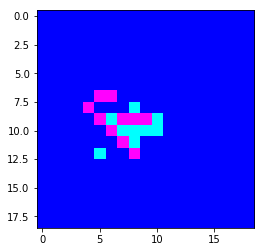

Game Over
Outcome: 0.09347630396922774  Action: (9, 9)
Outcome: -0.0  Action: (10, 8)
Outcome: 0.11954281298598045  Action: (9, 7)
Outcome: 0.03514177322837281  Action: (8, 8)
Outcome: 0.2631886088105734  Action: (9, 8)
Outcome: -0.02050493799078456  Action: (9, 10)
Outcome: 0.15689635786822267  Action: (11, 7)
Outcome: 0.029288495973527146  Action: (10, 10)
Outcome: 0.23294830356431562  Action: (9, 5)
Outcome: -0.11665398867074886  Action: (10, 7)
Outcome: 0.3429411334713946  Action: (7, 5)
Outcome: 0.0963795889995146  Action: (9, 6)
Outcome: 0.13683162776087632  Action: (7, 6)
Outcome: 0.35835739835078595  Action: (12, 5)
Outcome: 0.21346299087202542  Action: (10, 6)
Outcome: 0.24400045983060528  Action: (10, 9)
Outcome: 0.35067302243502596  Action: (12, 8)
Outcome: 0.04976354802793381  Action: (11, 8)
Outcome: 1  Action: (8, 4)


In [5]:
game.draw() 
plt.show()
for i in range(40):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [24]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

In [25]:
hidden_layer_count = 512

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=3)(x)

pmx = Conv2D(hidden_layer_count, (10,10), padding='same', activation='relu')(x)
pmx = Conv2D(hidden_layer_count, (10,10), padding='same', activation='relu')(pmx)
pmx = Conv2D(1, (1,1), padding='same', activation='relu')(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

wx = Conv2D(hidden_layer_count, (10,10), padding='valid', activation='relu')(x)
wx = Conv2D(hidden_layer_count, (10,10), padding='valid', activation='relu')(wx)
wx = GlobalMaxPooling2D()(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)

model = Model(input_state, [prob_map, winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy', 'mean_squared_error'],
    loss_weights=[1, shape[0]*shape[1]]
)

# Pre train with hand crafted model

In [8]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(1):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [9]:
from os import listdir
from os.path import isfile, join

In [19]:
data_path = '/data/gomoku_alpha_zero'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [21]:
train_boards = []
train_scores = []
train_actions = []

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.ones(shape)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [22]:
len(train_actions)

21419

In [26]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=1)

Epoch 1/1
21419/21419 [==============================] - 250s 12ms/step - loss: 278.8121 - prob_map_loss: 5.8889 - winner_loss: 0.7560


# Reenforment learning

In [27]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def predicted_outcome(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        return pred[1][0][0]

    def most_probable_actions(self, game, max_branching):
        return list(set(choice2d(self.get_probability_map(game), max_branching)))
    
    def get_probability_map(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        pmap = np.multiply(pred[0][0].reshape(game.get_shape()), 1-game.get_occupied())
        return pmap / np.sum(pmap) 

In [28]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = MonteCarloTreeSearch(game, LearnedGomokuModel(model), 2, 10)
results = []

Outcome: -1/1.0  Action: (2, 7)


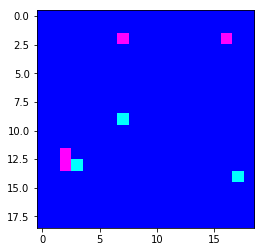

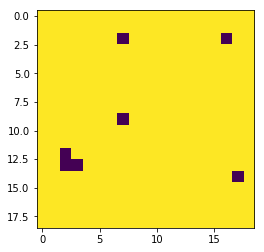

KeyboardInterrupt: 

In [29]:
game.draw() 
plt.show()
for i in range(40):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    predicted_outcome = lmodel.predicted_outcome(game)
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "/" + str(predicted_outcome) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()
    plt.imshow(lmodel.get_probability_map(game))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

In [ ]:
#lmodel = LearnedGomokuModel(model)
lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))

In [ ]:
model.save_weights('/data/gomoku_alpha_zero/v1.h5')